In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

### Dataset
Created by Intel for an image classification contest, this expansive image dataset contains approximately 25,000 images. Furthermore, the images are divided into the following categories: buildings, forest, glacier, mountain, sea, and street. The dataset has been divided into folders for training, testing, and prediction. The training folder includes around 14,000 images and the testing folder has around 3,000 images. Finally, the prediction folder includes around 7,000 images. 

### Goal
Our main goal in this project is to train a Convolutional Neural Network in order to predict the content of our test images

Let's get the train and test images from their distinct folders 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

train_dir = 'data/seg_train'
train_imgs = datagen.flow_from_directory(train_dir,target_size=(150,150), class_mode='categorical', batch_size = 14034)

test_dir = 'data/seg_test'
test_imgs = datagen.flow_from_directory(test_dir,target_size=(150,150), class_mode='categorical', batch_size = 3000)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [3]:
'train shape: {}'.format(train_imgs[0][0].shape)

'train shape: (14034, 150, 150, 3)'

In [4]:
'test shape: {}'.format(test_imgs[0][0].shape)

'test shape: (3000, 150, 150, 3)'

In [5]:
# rescale the data from (0,255) to (0,1)
x_train = train_imgs[0][0]
y_train = train_imgs[0][1]
x_train /= 255

x_test = test_imgs[0][0]
y_test = test_imgs[0][1]
x_test /= 255

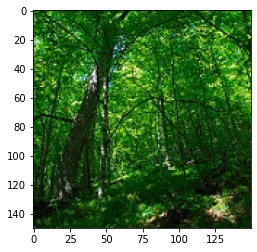

In [6]:
plt.imshow(x_train[0])

### Transfer learning

In [7]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [34]:
input_shape = (150, 150, 3)
classes = 6

In [35]:
vgg = VGG16(include_top=False,input_shape = input_shape, classes = classes)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [25]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [38]:
x = Flatten(name='flatten')(vgg.output)
x = Dense(2048, activation='relu', name='fc1')(x)
x = Dense(2048, activation='relu', name='fc2')(x)
x = Dense(classes, activation='softmax', name='predictions')(x)



vgg_model = Model(inputs = vgg.input, outputs = x, name = 'my_vgg')
vgg_model.summary()

Model: "my_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0    

In [44]:
for layer in vgg_model.layers[0:15]:
    layer.trainable = False
vgg_model.summary()

In [46]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
vgg_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

vgg_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
439/439 [==============================] - 1102s 3s/step - loss: 1.5703 - accuracy: 0.5018 - val_loss: 0.5185 - val_accuracy: 0.8310
Epoch 2/5
439/439 [==============================] - 1096s 2s/step - loss: 0.5061 - accuracy: 0.8510 - val_loss: 0.4362 - val_accuracy: 0.8453
Epoch 3/5
439/439 [==============================] - 1136s 3s/step - loss: 0.3759 - accuracy: 0.8875 - val_loss: 0.3956 - val_accuracy: 0.8887
Epoch 4/5
439/439 [==============================] - 1120s 3s/step - loss: 0.3235 - accuracy: 0.9019 - val_loss: 1.2864 - val_accuracy: 0.8393
Epoch 5/5
439/439 [==============================] - 1112s 3s/step - loss: 0.3074 - accuracy: 0.9160 - val_loss: 0.5256 - val_accuracy: 0.8827


In [47]:
vgg_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=2,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/2
439/439 [==============================] - 1094s 2s/step - loss: 0.3070 - accuracy: 0.9267 - val_loss: 0.6518 - val_accuracy: 0.8867
Epoch 2/2
439/439 [==============================] - 1092s 2s/step - loss: 0.2384 - accuracy: 0.9344 - val_loss: 0.9413 - val_accuracy: 0.8943


In [48]:
vgg_model.save('models/vgg_TL.h5')

### Models

In [10]:
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

#### Let's start by building a CNN with only 2 convolutional layers and 1 hidden layer of 512 nodes

In [20]:
num_classes = len(y_train[0])

model_1 = Sequential()

model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', input_shape=x_train[0].shape))
model_1.add(Activation('relu'))

model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 18 x 18 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 18x18x32 into 10368x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))


model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 75, 75, 32)        2432      
_________________________________________________________________
activation_4 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 32)        25632     
_________________________________________________________________
activation_5 (Activation)    (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)            

In [21]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
439/439 [==============================] - 71s 160ms/step - loss: 1.2766 - accuracy: 0.4961 - val_loss: 0.8281 - val_accuracy: 0.6950
Epoch 2/5
439/439 [==============================] - 71s 161ms/step - loss: 0.7802 - accuracy: 0.7162 - val_loss: 0.8187 - val_accuracy: 0.6983
Epoch 3/5
439/439 [==============================] - 72s 163ms/step - loss: 0.6558 - accuracy: 0.7669 - val_loss: 0.7442 - val_accuracy: 0.7293
Epoch 4/5
439/439 [==============================] - 71s 162ms/step - loss: 0.5506 - accuracy: 0.8059 - val_loss: 0.6632 - val_accuracy: 0.7737
Epoch 5/5
439/439 [==============================] - 71s 161ms/step - loss: 0.4874 - accuracy: 0.8332 - val_loss: 0.7100 - val_accuracy: 0.7580


#### Let's build a CNN with 2 convolutional layers and 2 hidden layers of 512 nodes (we increased the depth of the hidden layers by 1)

In [24]:
model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', input_shape=x_train[0].shape))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (2,2)))
model_2.add(Activation('relu'))

## 2x2 max pooling reduces to 18 x 18 x 32
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

## Flatten turns 18x18x32 into 10368x1
model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))


model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 75, 75, 32)        2432      
_________________________________________________________________
activation_8 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 32)        25632     
_________________________________________________________________
activation_9 (Activation)    (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10368)            

In [25]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
439/439 [==============================] - 73s 165ms/step - loss: 1.3764 - accuracy: 0.4462 - val_loss: 0.9170 - val_accuracy: 0.6367
Epoch 2/5
439/439 [==============================] - 77s 175ms/step - loss: 0.8900 - accuracy: 0.6705 - val_loss: 0.7878 - val_accuracy: 0.6963
Epoch 3/5
439/439 [==============================] - 74s 168ms/step - loss: 0.7118 - accuracy: 0.7452 - val_loss: 0.8376 - val_accuracy: 0.7307
Epoch 4/5
439/439 [==============================] - 72s 165ms/step - loss: 0.6196 - accuracy: 0.7830 - val_loss: 0.8459 - val_accuracy: 0.7330
Epoch 5/5
439/439 [==============================] - 72s 164ms/step - loss: 0.5288 - accuracy: 0.8181 - val_loss: 0.7230 - val_accuracy: 0.7383


We can see that we got worse accuracy

#### Let's build again a CNN with 2 convolutional layers and 1 hidden layer of 512 nodes but this time we will use 48 and 128 kernels in the convolutional layers

In [27]:
model_3 = Sequential()

model_3.add(Conv2D(48, (5, 5), strides = (2,2), padding='same', input_shape=x_train[0].shape))
model_3.add(Activation('relu'))

model_3.add(Conv2D(128, (5, 5), strides = (2,2)))
model_3.add(Activation('relu'))

## 2x2 max pooling reduces to 18 x 18 x 128
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

## Flatten turns 18 x 18 x 128 into 41472x1
model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))


model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 75, 75, 48)        3648      
_________________________________________________________________
activation_17 (Activation)   (None, 75, 75, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 36, 128)       153728    
_________________________________________________________________
activation_18 (Activation)   (None, 36, 36, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)            

In [28]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_3.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
439/439 [==============================] - 186s 421ms/step - loss: 1.3841 - accuracy: 0.4996 - val_loss: 0.7642 - val_accuracy: 0.7270
Epoch 2/5
439/439 [==============================] - 186s 423ms/step - loss: 0.7953 - accuracy: 0.7117 - val_loss: 0.7535 - val_accuracy: 0.7260
Epoch 3/5
439/439 [==============================] - 185s 421ms/step - loss: 0.6344 - accuracy: 0.7731 - val_loss: 0.5958 - val_accuracy: 0.7867
Epoch 4/5
439/439 [==============================] - 185s 422ms/step - loss: 0.5397 - accuracy: 0.8164 - val_loss: 0.7469 - val_accuracy: 0.7593
Epoch 5/5
439/439 [==============================] - 187s 427ms/step - loss: 0.4501 - accuracy: 0.8483 - val_loss: 0.7573 - val_accuracy: 0.7650


#### Let's further increase our network by building a CNN with 3 convolutional layers and 2 hidden layers, both of 2048 nodes

In [31]:
model_4 = Sequential()

model_4.add(Conv2D(48, (5, 5), strides = (2,2), padding='same', input_shape=x_train[0].shape))
model_4.add(Activation('relu'))

model_4.add(Conv2D(128, (5, 5), strides = (2,2)))
model_4.add(Activation('relu'))

model_4.add(Conv2D(192, (5, 5), strides = (2,2)))
model_4.add(Activation('relu'))

## max pooling reduces to 8 x 8 x 192
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

## Flatten turns 8x8x192 into 12288x1
model_4.add(Flatten())

# FC layers
model_4.add(Dense(2048))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(2048))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes))
model_4.add(Activation('softmax'))


model_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 75, 75, 48)        3648      
_________________________________________________________________
activation_33 (Activation)   (None, 75, 75, 48)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 36, 36, 128)       153728    
_________________________________________________________________
activation_34 (Activation)   (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 192)       614592    
_________________________________________________________________
activation_35 (Activation)   (None, 16, 16, 192)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 192)        

In [32]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_4.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_4.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
439/439 [==============================] - 280s 637ms/step - loss: 1.4662 - accuracy: 0.4419 - val_loss: 0.8614 - val_accuracy: 0.6793
Epoch 2/5
439/439 [==============================] - 281s 640ms/step - loss: 0.8511 - accuracy: 0.6898 - val_loss: 0.8215 - val_accuracy: 0.7047
Epoch 3/5
439/439 [==============================] - 280s 638ms/step - loss: 0.6901 - accuracy: 0.7619 - val_loss: 1.7743 - val_accuracy: 0.5750
Epoch 4/5
439/439 [==============================] - 279s 636ms/step - loss: 0.7064 - accuracy: 0.7663 - val_loss: 0.8688 - val_accuracy: 0.7783
Epoch 5/5
439/439 [==============================] - 279s 636ms/step - loss: 0.5977 - accuracy: 0.8072 - val_loss: 1.4014 - val_accuracy: 0.6660


Not a desired outcome

#### Let's try something close to the vgg architecture with 4 convolutional layers and 2 fully connected layers

In [73]:
model_5 = Sequential()

model_5.add(Conv2D(64, (3,3), strides = (1,1), padding='same', input_shape=x_train[0].shape))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.25))

model_5.add(Conv2D(128, (3,3), strides = (1,1), padding='same', input_shape=x_train[0].shape))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.25))

model_5.add(Conv2D(256, (3,3), strides = (1,1), padding='same', input_shape=x_train[0].shape))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.25))

model_5.add(Conv2D(512, (3,3), strides = (1,1), padding='same', input_shape=x_train[0].shape))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.25))

## Flatten turns 9x9x512 into 41472x1
model_5.add(Flatten())

# FC layers
model_5.add(Dense(1024))
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(1024))
model_5.add(Activation('relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(num_classes))
model_5.add(Activation('softmax'))

model_5.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
activation_61 (Activation)   (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
activation_62 (Activation)   (None, 75, 75, 128)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 37, 37, 128)     

In [74]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_5.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_5.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
439/439 [==============================] - 842s 2s/step - loss: 1.7773 - accuracy: 0.4240 - val_loss: 0.7997 - val_accuracy: 0.7170
Epoch 2/10
439/439 [==============================] - 852s 2s/step - loss: 0.8083 - accuracy: 0.7016 - val_loss: 0.6203 - val_accuracy: 0.7837
Epoch 3/10
439/439 [==============================] - 857s 2s/step - loss: 0.6513 - accuracy: 0.7755 - val_loss: 0.8429 - val_accuracy: 0.7140
Epoch 4/10
439/439 [==============================] - 863s 2s/step - loss: 0.5653 - accuracy: 0.8076 - val_loss: 0.4963 - val_accuracy: 0.8403
Epoch 5/10
439/439 [==============================] - 856s 2s/step - loss: 0.5285 - accuracy: 0.8224 - val_loss: 0.5192 - val_accuracy: 0.8277
Epoch 6/10
439/439 [==============================] - 851s 2s/step - loss: 0.5104 - accuracy: 0.8395 - val_loss: 0.6473 - val_accuracy: 0.7753
Epoch 7/10
439/439 [==============================] - 853s 2s/step - loss: 0.5319 - accuracy: 0.8330 - val_loss: 0.5626 - val_accuracy: 0.8123

This model performed much better to the validation set compared to the previous one's

In [16]:
y_pred_prob = model_5.predict(x_test)
y_pred_class = model_5.predict_classes(x_test)

c:\users\dionisis\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#### Save models

In [99]:
model_1.save('models/model_1.h5')

#### Load models

In [15]:
from tensorflow.keras.models import load_model
model_5 = load_model('models/model_5.h5')

Let's take an example using our last model which achieved the best accuracy

propabilities:  [0.049 0.03  0.214 0.598 0.101 0.008]
class:  3
ground truth:  3


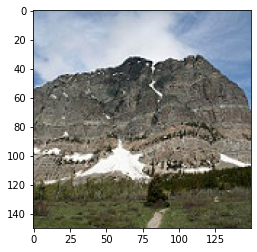

In [70]:
example = 15
plt.imshow(x_test[example])
print("propabilities: ", np.round(y_pred_prob[example], 3))
print("class: ", y_pred_class[example])
print("ground truth: ", np.argmax(y_test[example]))

Our classes are in alphabetical order which means:
* 0: Buildings
* 1: Forest
* 3: Glacier
* 4: Mountain
* 5: Sea
* 6: Street

In [50]:
def get_class(num):

    if num == 0:
        return 'Building'
    if num == 1:
        return 'Forest'
    if num == 2:
        return 'Glacier'
    if num == 3:
        return 'Mountain'
    if num == 4:
        return 'Sea'
    if num == 5:
        return 'Street'
    

And some more examples on the train set

<ipython-input-128-6b45eccdbd8b>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row][col].set_yticklabels(['','Building','Forest','Glacier',


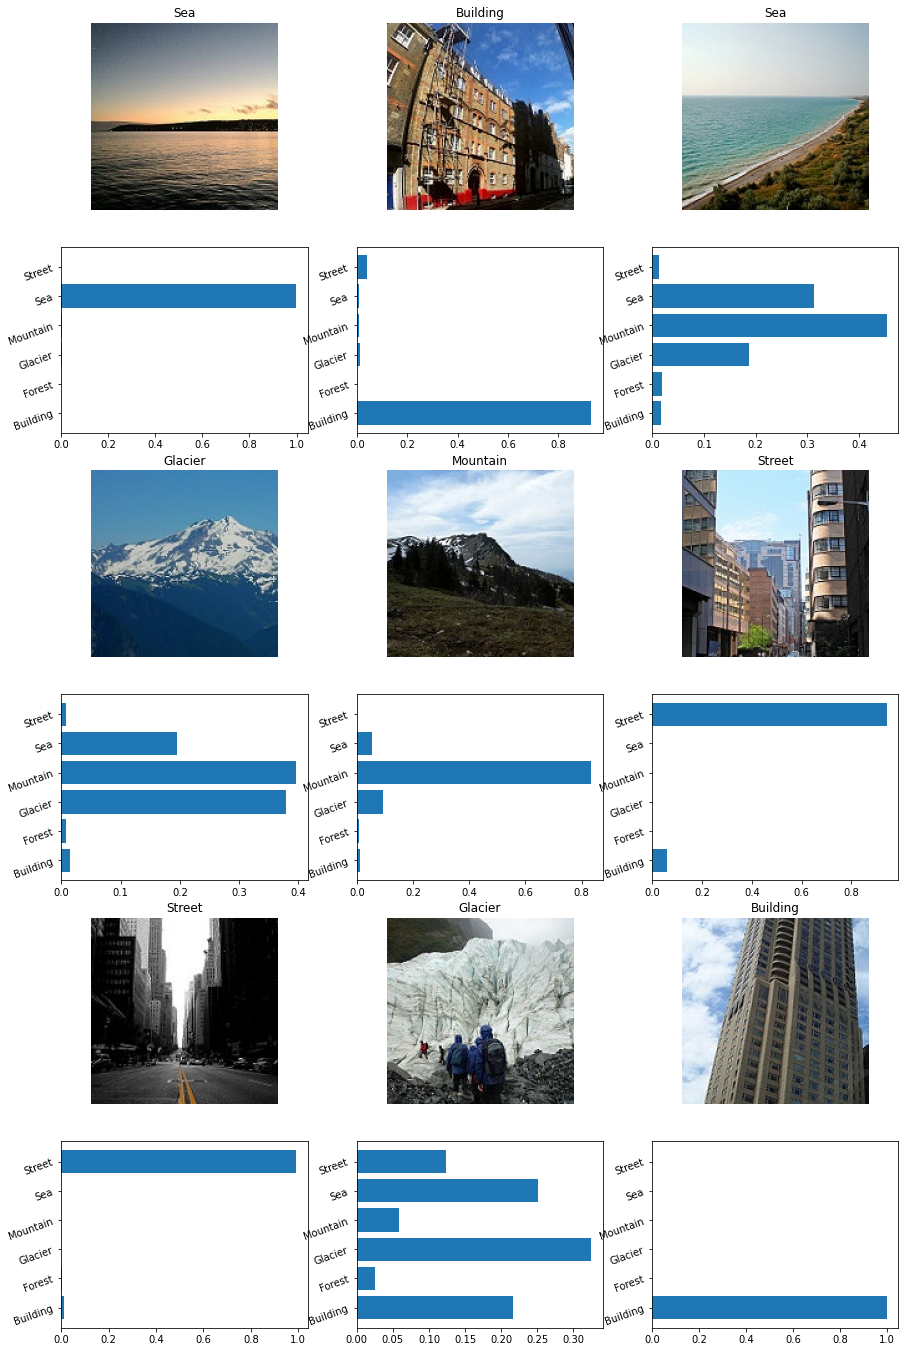

In [128]:
fig, ax = plt.subplots(6,3, figsize = (15, 24))
example = 0

for row in range(6):
    if (row%2 != 0):
        example -= 3
    for col in range(3):
        c = get_class(y_pred_class[example])
        gt = get_class(np.argmax(y_test[example]))
        certainty = np.round(np.max(y_pred_prob[example])  * 100, 2)
        
        # PLOTS
        if (row%2 == 0):
            #print("Image", example+1, "| Prediction:", c,"with",certainty, "% certainty | Ground Truth:", gt)
            
            ax[row][col].set_title(gt)
            ax[row][col].imshow(x_test[example])
            ax[row][col].axis('off')
        else:   
            ax[row][col].barh([0,1,2,3,4,5], y_pred_prob[example])
            fig.add_subplot(ax[row][col])
            
            ax[row][col].set_yticklabels(['','Building','Forest','Glacier',
                                          'Mountain','Sea','Street'], rotation = 20)
            
        example += 1     


#### Key findings
* The validation accuracy of each epoch has many ups and downs
* We can see above that the neural network may produce wrong predictions in examples that even us could get wrong (in Image 4 predicted mountain while it was glacier).
* There are also images - like the 3rd one - where it seems pretty easy for the human eye to distinguish the content while our model predicted wrong.
* Also, we noticed that the last model which has a similar architecture to the VGG network (with one less convolutional layer and 1 less Dense layer), achieved the best validation score.